# <center>  [SF-DST] Booking reviews </center>

Признаки

- hotel_address - адрес отеля
- review_date - дата, когда рецензент разместил соответствующий отзыв.
- average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- hotel_name - название отеля
- reviewer_nationality - национальность рецензента
- negative_review - отрицательный отзыв, который рецензент дал отелю.
- review_total_negative_word_counts - общее количество слов в отрицательном отзыв
- positive_review - положительный отзыв, который рецензент дал отелю
- review_total_positive_word_counts - общее количество слов в положительном отзыве
- reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
- total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
- total_number_of_reviews - общее количество действительных отзывов об отеле
- tags - теги, которые рецензент дал отелю.
- days_since_review - продолжительность между датой проверки и датой очистки
- additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв.Это число указывает, сколько там действительных оценок без проверки.
- lat - широта отеля
- lng - долгота отеля

### Цель: создать модель для предсказания рейтинга отеля. 

In [78]:
%pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import re 
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

In [80]:
df_train=pd.read_csv('/Users/ulabakulina/Desktop/piton/sf-booking/hotels_train.csv')
df_test=pd.read_csv('/Users/ulabakulina/Desktop/piton/sf-booking/hotels_test.csv')

Обработку всех данных будем проводить совместно, для этого создадим новый столбец Sample, в который занесем метки: которые будут обозначать тренировочные и тестовые наборы. 

In [81]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score']= 0


In [82]:
df_test.shape, df_train.shape

((128935, 18), (386803, 18))

In [83]:
df=pd.concat([df_train, df_test])

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515738 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 10  r

С помощью библиотеки profiling сделаем предварительный анализ датасета.

In [85]:
profile=(ProfileReport(df))

Так как при загрузке в GitHab не отображается корректно тетрадь, было принято решение закомментировать показ отчетности ProfileReport.

In [86]:
#profile

С помощью библиотеки Profile мы заметили что у нас есть проблемные места в виде пропусков, дубликатов, есть признаки с высокой корреляцией additional_number_of_scoring и total_number_of_reviews. 

In [87]:
df.describe().round(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.00,515738.00,515738.00,515738.00,515738.00,515738.00,515738.00,512470.00,512470.00,515738.00
mean,498.08,8.40,18.54,2743.74,17.78,7.17,6.30,49.44,2.82,0.75
std,500.54,0.55,29.69,2317.46,21.80,11.04,3.90,3.47,4.58,0.43
min,1.00,5.20,0.00,43.00,0.00,1.00,0.00,41.33,-0.37,0.00
25%,169.00,8.10,2.00,1161.00,5.00,1.00,0.62,48.21,-0.14,0.25
50%,341.00,8.40,9.00,2134.00,11.00,3.00,7.90,51.50,0.01,1.00
75%,660.00,8.80,23.00,3613.00,22.00,8.00,9.60,51.52,4.83,1.00
max,2682.00,9.80,408.00,16670.00,395.00,355.00,10.00,52.40,16.43,1.00


In [88]:
df.describe(include=[object])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


После объединения значений 515 тыс.наблюдений, 307 дубликатов, 8 категориальных признаков и 9 - числовых. Пропуски имеют колонки lat и lng. Налюдается высокая коррекляция между признаком additional_number_of_scoring и total_number_of_reviews.

### Обработка и очистка данных. 

In [89]:
df.drop_duplicates(inplace=True)

Удалили дубликаты. 

In [90]:
def clear_tags (tag):
    result=re.findall("'[^\'](.+?)[^\']'", tag)
    return result 
df['tags']=df.tags.apply(clear_tags)
df=df.explode('tags')
df.tags.value_counts().head(10)

tags
Leisure trip                      417513
Submitted from a mobile device    307458
Couple                            252117
Stayed 1 night                    193557
Stayed 2 nights                   133846
Solo traveler                     108468
Stayed 3 nights                    95754
Business trip                      82880
Group                              65357
Family with young children         60986
Name: count, dtype: int64

По количеству наблюдений преобладает Leisure trip с количеством 417513.

In [91]:
df['les_trip']=0
df['les_trip']=df['tags'].apply(lambda x: 1 if x.find('Leisure trip')!= -1 else 0)

In [92]:
df['sub_mob_dev'] = 0
df['sub_mob_dev'] = df['tags'].apply(lambda x: 1 if x.find('Submitted from a mobile device')!= -1 else 0)
df['cop'] = 0
df['cop'] = df['tags'].apply(lambda x: 1 if x.find('Couple')!= -1 else 0)
df['st_1_n'] = 0
df['st_1_n'] = df['tags'].apply(lambda x: 1 if x.find('Stayed 1 night')!= -1 else 0)
df['st_2_n'] = 0
df['st_2_n'] = df['tags'].apply(lambda x: 1 if x.find('Stayed 2 nights')!= -1 else 0)
df['solo_tr'] = 0
df['solo_tr'] = df['tags'].apply(lambda x: 1 if x.find('Solo traveler')!= -1 else 0)
df['st_3_n'] = 0
df['st_3_n'] = df['tags'].apply(lambda x: 1 if x.find('Stayed 3 nights')!= -1 else 0)
df['bus_tr'] = 0
df['bus_tr'] = df['tags'].apply(lambda x: 1 if x.find('Business trip')!= -1 else 0)
df['grp'] = 0
df['grp'] = df['tags'].apply(lambda x: 1 if x.find('Group')!= -1 else 0)
df['fam_ch'] = 0
df['fam_ch'] = df['tags'].apply(lambda x: 1 if x.find('Family with young children')!= -1 else 0)

Выявили наиболее популярные теги, на основе которых сделали 10 признаков. Колонка tags отработала и мы ее удаляем.

In [93]:
df=df.drop('tags', axis=1)

In [94]:
df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,sample,les_trip,sub_mob_dev,cop,st_1_n,st_2_n,solo_tr,st_3_n,bus_tr,grp,fam_ch
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,1,0,0,0,0,0,0,0,0,0
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,0,1,0,0,0,0,0,0,0
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,0,0,0,0,0,0,0,0,0
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,0,0,0,1,0,0,0,0,0
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,1,0,0,0,0,0,0,0,0


In [95]:
df['City']=df.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
df['Country']=df.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])

In [96]:
sns.countplot(df['City'])
plt.title('Города с отелями')
plt.show()

/var/folders/4p/61221tbs1lq96mmqjjf1m7m40000gn/T/ipykernel_8221/1026704009.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [97]:
sns.countplot(df['Country'])
plt.title('Страны с отелями')
plt.show()

/var/folders/4p/61221tbs1lq96mmqjjf1m7m40000gn/T/ipykernel_8221/3920564910.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



По наличию отелей преобладают города - London, а из стран - United Kingdom.

In [98]:
hotel_count=df.groupby('Country')['hotel_name'].count()

Из-за некоррктного отображения ноутбука мы закодировали ячейчки.

In [99]:
#fig=px.choropleth(locations=hotel_count.index,locationmode='country names',scope='europe', color=np.log(hotel_count.values))
#fig.show()

Из графика видим, что больше всего отелей расположено во Франции, на втором месте - Англия, а на третьем - Испания. 

Эти признаки одинаковые, поэтому приняли решение удалить признаки hotel_address и Country. Затем City закодируем с помощью labelEncoder.

In [100]:
df=df.drop(['hotel_address', 'Country'], axis=1)

In [101]:
df.duplicated().sum()

np.int64(122001)

In [102]:
df.drop_duplicates(inplace=True)

In [103]:
enc = OneHotEncoder(sparse_output=True)
encod_data = enc.fit_transform(df[["City"]]).toarray()

In [104]:
df=df.drop(['City'],axis=1)

In [105]:
df = df.reset_index(drop=True)

In [106]:
encode_df = pd.DataFrame(encod_data, columns=enc.get_feature_names_out(['City']))
df=pd.concat([df,encode_df], axis=1)

In [107]:
nat=df['reviewer_nationality'].value_counts().nlargest(10).index 
df['reviewer_nationality']=df['reviewer_nationality'].apply(lambda x: x if x in nat else 'other')

In [108]:
sns.countplot(df['reviewer_nationality'])
plt.title('Национальность рецензента')
plt.show()

/var/folders/4p/61221tbs1lq96mmqjjf1m7m40000gn/T/ipykernel_8221/3778671175.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [109]:
encod_data = enc.fit_transform(df[["reviewer_nationality"]]).toarray()
encode_df = pd.DataFrame(encod_data, columns=enc.get_feature_names_out(['reviewer_nationality']))
df=pd.concat([df,encode_df],axis=1)

In [110]:
pd.set_option('display.max_columns', None)

In [111]:
df.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,sample,les_trip,sub_mob_dev,cop,st_1_n,st_2_n,solo_tr,st_3_n,bus_tr,grp,fam_ch,City_Amsterdam,City_Barcelona,City_London,City_Milan,City_Paris,City_Vienna,reviewer_nationality_ Australia,reviewer_nationality_ Canada,reviewer_nationality_ Germany,reviewer_nationality_ Ireland,reviewer_nationality_ Netherlands,reviewer_nationality_ Saudi Arabia,reviewer_nationality_ Switzerland,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ United Kingdom,reviewer_nationality_ United States of America,reviewer_nationality_other
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


 Данный признак - days_since_review, может нам пригодиться для выявления закономерностей, поэтому мы его очистим от лишних символов. 

In [112]:
df['days_since_review']=df['days_since_review'].apply(lambda x: int(x.replace(' day', '').replace('s', '')))

Те признаки, которые нам не потребуются в процессе обучения модели - удаляем. 

In [113]:
df=df.drop(['negative_review', 'positive_review', 'reviewer_nationality', 'review_date', 'hotel_name', 'lat', 'lng'], axis=1)

In [114]:
df.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,sample,les_trip,sub_mob_dev,cop,st_1_n,st_2_n,solo_tr,st_3_n,bus_tr,grp,fam_ch,City_Amsterdam,City_Barcelona,City_London,City_Milan,City_Paris,City_Vienna,reviewer_nationality_ Australia,reviewer_nationality_ Canada,reviewer_nationality_ Germany,reviewer_nationality_ Ireland,reviewer_nationality_ Netherlands,reviewer_nationality_ Saudi Arabia,reviewer_nationality_ Switzerland,reviewer_nationality_ United Arab Emirates,reviewer_nationality_ United Kingdom,reviewer_nationality_ United States of America,reviewer_nationality_other
0,581,8.4,3,1994,4,7,10.0,531,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,581,8.4,3,1994,4,7,10.0,531,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,581,8.4,3,1994,4,7,10.0,531,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,581,8.4,3,1994,4,7,10.0,531,1,0,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,581,8.4,3,1994,4,7,10.0,531,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


---

### Обучение модели

In [115]:
train_df=df.query('sample == 1').drop(['sample'], axis = 1)
test_df=df.query('sample == 0').drop(['sample'], axis = 1)

In [116]:
y=train_df.reviewer_score.values
x=train_df.drop(['reviewer_score'],axis=1)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [118]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1339739, 34), (334935, 34), (1339739,), (334935,))

In [77]:
regr = RandomForestRegressor(n_estimators=100)  
      
regr.fit(X_train, y_train)  

y_pred = regr.predict(X_test)  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 13.14416


In [42]:
plt.rcParams['figure.figsize'] = (8,4)
feat_importances = pd.Series(regr.feature_importances_, index=x.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Важность признаков')

Text(0.5, 1.0, 'Важность признаков')

Проверим качество модели на обучающие выборки. 

In [46]:
test_df.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'les_trip', 'sub_mob_dev', 'cop', 'st_1_n',
       'st_2_n', 'solo_tr', 'st_3_n', 'bus_tr', 'grp', 'fam_ch',
       'City_Amsterdam', 'City_Barcelona', 'City_London', 'City_Milan',
       'City_Paris', 'City_Vienna', 'reviewer_nationality_ Australia ',
       'reviewer_nationality_ Canada ', 'reviewer_nationality_ Germany ',
       'reviewer_nationality_ Ireland ', 'reviewer_nationality_ Netherlands ',
       'reviewer_nationality_ Saudi Arabia ',
       'reviewer_nationality_ Switzerland ',
       'reviewer_nationality_ United Arab Emirates ',
       'reviewer_nationality_ United Kingdom ',
       'reviewer_nationality_ United States of America ',
       'reviewer_nationality_other'],
      dtype='object')

In [47]:
test_df.drop('reviewer_score', axis=1, inplace=True)

In [48]:
predict=regr.predict(test_df)

Подгружаем файлик 'submission' для заполнения столбца с предсказаниями.

In [55]:
sub=pd.read_csv('/Users/ulabakulina/Desktop/piton/sf-booking/submission_orig.csv')

In [56]:
sub.shape

(128935, 2)

In [57]:
df_test.shape

(128935, 18)

In [ ]:
sub['reviewer_score']=predict 
sub.to_csv('submission_kaggle.csv',index=False)

![Снимок экрана 2025-05-28 в 17.14.44.png](<attachment:Снимок экрана 2025-05-28 в 17.14.44.png>)
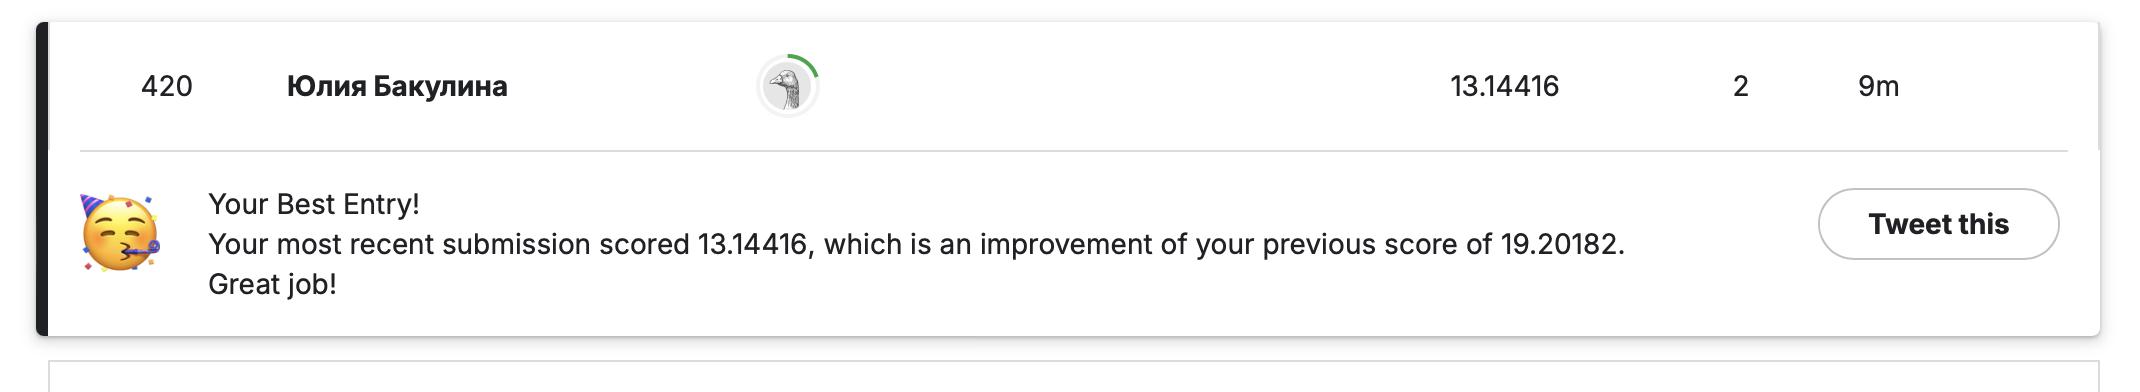

Итоговая метрика: 13.14416